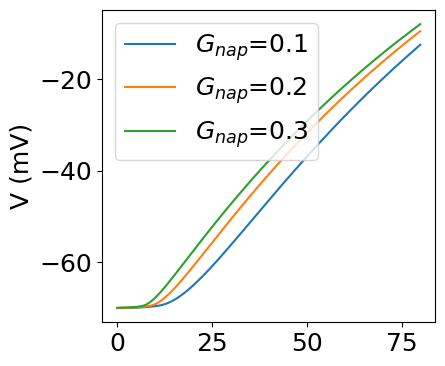

In [98]:
##single EPSPs - Inap

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
plt.rcParams.update({'font.size': 18})

def signal_trend(data):
    if np.argmin(data) > len(data)-3:
        return "decreasing"
    elif np.argmin(data) < 3:
        return "increasing"
    else:
        return "peaking"


plt.figure(figsize=(12,4))

for gnapbar in [0.1, 0.2, 0.3]:
    delay=0
    count=0

    width_block=1
    frequency = 120 #Hz

    for a in [1]:#np.arange(1,10,10):

        for b in [8]:#np.arange(1,10,2):

            g_AMPA_ext_E = 1#100.08 #nS
            tau_1 = a #ms
            tau_2 = 10 #ms

            g_GABA_E = 1 #nS
            tau_1g = b #10. #ms
            tau_2g = 10

            t = 80
            
            dt = 0.1
            N = round(t/dt)
            ttotal = np.arange(0,t,dt)

            ## signal
            tspks = np.linspace(0,t,int(frequency/10))
            tspksi = [int(x/dt) for x in tspks]
            tspksf = [int((x+width_block)/dt) for x in tspks]
            amp=1
            syn = np.zeros_like(ttotal)
            for i in range(len(tspksi)):
                syn[tspksi[i]:tspksf[i]]=amp

            lat_e=1
            syn_ampa = np.zeros_like(ttotal)
            for o in range(len(tspksi)):
                syn_ampa[int(tspksi[o] + int(lat_e / dt)):int(tspksf[o] + int(lat_e / dt))] = 1  # Convert to int

            lat_i=2
            syn_gaba = np.zeros_like(ttotal)
            for o in range(len(tspksi)):
                syn_gaba[int(tspksi[o] + int(lat_i / dt)):int(tspksf[o] + int(lat_i / dt))] = 1  # Convert to int

            s_AMPA=0
            x_ampa=0

            s_GABA=0
            x_gaba=0

            Iacum_AMPA = []
            Iacum_GABA = []
            IacumCo =[ ]

            sg =[]
            sa = []

            ####neuron parameters
            v_soma = -70
            v_dend = -70
            gleak_soma = 1*(10**-4)
            gleak_dend = 1*(10**-4)
            Eleak_soma = -70
            Eleak_dend = -70
            vacum_soma = []
            vacum_dend = []

            ####second neuron
            v_soma2 = -70
            v_dend2 = -70
            vacum_soma2 = []
            vacum_dend2 = []

            ##ionic currrents
            mtau_p = 0.5
            Enap = 50
            minf_p = lambda x: 1/(1+np.exp(-(x+55)/2.8))	
            mp = 0
            mp2=0
            inapacum =[]

            ####Coupling parameters
            g_coupling = 0.01  # coupling conductance

            #transient
            for i in range(round(10/dt)):

                #### Calculate Ionic Current for Soma
                Ileak_soma = gleak_soma * (v_soma - Eleak_soma)

                #### Calculate Ionic Current for Dendrite
                Ileak_dend = gleak_dend * (v_dend - Eleak_dend)
                Inap = gnapbar*mp*(v_dend - Enap)
                # inapacum.append(Inap)

                #### Calculate Coupling Current
                I_coupling = g_coupling * (v_soma - v_dend)

                #### Calculate Total Current for Soma and Dendrite
                I_total_soma =  - Ileak_soma - I_coupling #+ IacumCo[-1] #Iacum_GABA[-1] + Iacum_AMPA[-1]
                I_total_dend = - Ileak_dend + I_coupling - Inap

                #### Update Membrane Potentials
                v_soma = v_soma + dt * I_total_soma
                v_dend = v_dend + dt * I_total_dend
                mp = mp + dt* (minf_p(v_dend) - mp) / mtau_p


            for i in range(N):
                #vpre ---> I -> vpost

                s_AMPA =  s_AMPA + dt*( ((tau_2/tau_1) ** (tau_1 / (tau_2 - tau_1))*x_ampa-s_AMPA)/tau_1 )
                x_ampa = x_ampa + dt*(-x_ampa/tau_2 + syn_ampa[i])
                Iacum_AMPA.append(s_AMPA)

                s_GABA = g_GABA_E * s_GABA + dt*( ((tau_2g/tau_1g) ** (tau_1g / (tau_2g - tau_1g))*x_gaba-s_GABA)/tau_1g )
                x_gaba = x_gaba + dt*(-x_gaba/tau_2g + syn_gaba[i])
                Iacum_GABA.append(-s_GABA)
                
                IacumCo.append(s_GABA-s_AMPA)

                #### Calculate Ionic Current for Soma
                Ileak_soma = gleak_soma * (v_soma - Eleak_soma)

                #### Calculate Ionic Current for Dendrite
                Ileak_dend = gleak_dend * (v_dend - Eleak_dend)
                Inap = gnapbar*mp*(v_dend - Enap)
                # inapacum.append(Inap)

                #### Calculate Coupling Current
                I_coupling = g_coupling * (v_soma - v_dend)

                #### Calculate Total Current for Soma and Dendrite
                I_total_soma =  - Ileak_soma - I_coupling #+ IacumCo[-1] #Iacum_GABA[-1] + Iacum_AMPA[-1]
                I_total_dend = - Ileak_dend + I_coupling - Inap + g_AMPA_ext_E * Iacum_AMPA[-1]

                #### Update Membrane Potentials
                v_soma = v_soma + dt * I_total_soma
                v_dend = v_dend + dt * I_total_dend
                mp = mp + dt* (minf_p(v_dend) - mp) / mtau_p

                vacum_soma.append(v_soma)
                vacum_dend.append(v_dend)

                #### Calculate Total Current for Soma and Dendrite second neuron
                Ileak_soma = gleak_soma * (v_soma2 - Eleak_soma)
                Ileak_dend = gleak_dend * (v_dend2 - Eleak_dend)
                I_coupling = g_coupling * (v_soma2 - v_dend2)
                Inap = gnapbar*mp2*(v_dend2 - Enap)
                inapacum.append(mp2)
                I_total_soma =  - Ileak_soma - I_coupling #+ Iacum_GABA[-1] 
                I_total_dend = - Ileak_dend + I_coupling + Iacum_AMPA[-1] - Inap

                #### Update Membrane Potentials
                v_soma2 = v_soma2 + dt * I_total_soma
                v_dend2 = v_dend2 + dt * I_total_dend
                mp2 = mp2 + dt* (minf_p(v_dend2) - mp2) / mtau_p

                vacum_soma2.append(v_soma2)
                vacum_dend2.append(v_dend2)

            peaks_AMPA, _ = find_peaks(Iacum_AMPA)
            peaks_GABA, _ = find_peaks(Iacum_GABA)

            Iacum_AMPA = np.asarray(Iacum_AMPA)
            Iacum_GABA = np.asarray(Iacum_GABA)

            filtered_signal_AMPA = gaussian_filter1d(Iacum_AMPA[peaks_AMPA], 4)
            filtered_signal_GABA = gaussian_filter1d(Iacum_GABA[peaks_GABA], 4)

            count = count + 1
            # plt.subplot(2, 3, count)

            # plt.plot(ttotal, Iacum_AMPA, c='b', label='AMPA')
            # plt.plot(ttotal, Iacum_GABA, c='r', label='GABA')
            # plt.plot(ttotal,IacumCo)
        
            # plt.plot(ttotal[peaks_AMPA], Iacum_AMPA[peaks_AMPA], 'bx')
            # plt.plot(ttotal[peaks_GABA], Iacum_GABA[peaks_GABA], 'rx')
            plt.subplot(1, 3, count)# + 3)
            
            # plt.title(r'$\Delta_\tau$' + f'={lat_e - lat_i}, $\Delta_g$ = {round(g_AMPA_ext_E - g_GABA_E, 2)}', fontsize=18)
            # plt.title(r'$\Delta_\tau rise$' + f'={tau_1-tau_1g}')
            # plt.title(f'AMPA: {signal_trend(filtered_signal_AMPA)}, GABA: {signal_trend(filtered_signal_GABA)}')

            # plt.xlabel('Time (ms)') 
            
            plt.plot(ttotal, vacum_soma, label=r'$G_{nap}$='+str(gnapbar))
            plt.legend()
            plt.ylabel('V (mV)')
            # plt.ylabel('Membrane Potential (mV)')

            # plt.subplot(2, 3, count+3)
            # plt.plot(ttotal, vacum_soma2)#,label='Mono-transmission')
            
            # # plt.plot(ttotal, vacum_dend, label='Dendrite', c='r')
            # plt.xlabel('Time (ms)')
            # plt.ylabel('Mono-transmission - V (mV)')
            # plt.legend()
            plt.tight_layout()

plt.savefig('inap_only.png')
plt.savefig('inap_only.pdf')
plt.show()

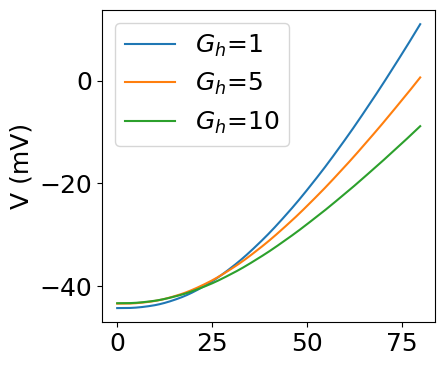

In [96]:
####### SOMA/DENDRITE COMPARTMENTS IN CORTICAL NEURONS

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
plt.rcParams.update({'font.size': 18})

def signal_trend(data):
    if np.argmin(data) > len(data)-3:
        return "decreasing"
    elif np.argmin(data) < 3:
        return "increasing"
    else:
        return "peaking"


plt.figure(figsize=(12,4))

for ghbar in [1, 5, 10]:

    delay=0
    count=0

    width_block=1
    frequency = 120 #Hz

    for a in [1]:#np.arange(1,10,10):

        for b in [8]:#np.arange(1,10,2):

            g_AMPA_ext_E = 2#100.08 #nS
            tau_1 = a #ms
            tau_2 = 10 #ms

            g_GABA_E = 1 #nS
            tau_1g = b #10. #ms
            tau_2g = 10

            t = 80
            
            dt = 0.1
            N = round(t/dt)
            ttotal = np.arange(0,t,dt)

            ## signal
            tspks = np.linspace(0,t,int(frequency/10))
            tspksi = [int(x/dt) for x in tspks]
            tspksf = [int((x+width_block)/dt) for x in tspks]
            amp=1
            syn = np.zeros_like(ttotal)
            for i in range(len(tspksi)):
                syn[tspksi[i]:tspksf[i]]=amp

            lat_e=1
            syn_ampa = np.zeros_like(ttotal)
            for o in range(len(tspksi)):
                syn_ampa[int(tspksi[o] + int(lat_e / dt)):int(tspksf[o] + int(lat_e / dt))] = 1  # Convert to int

            lat_i=2
            syn_gaba = np.zeros_like(ttotal)
            for o in range(len(tspksi)):
                syn_gaba[int(tspksi[o] + int(lat_i / dt)):int(tspksf[o] + int(lat_i / dt))] = 1  # Convert to int

            s_AMPA=0
            x_ampa=0

            s_GABA=0
            x_gaba=0

            Iacum_AMPA = []
            Iacum_GABA = []
            IacumCo =[ ]

            sg =[]
            sa = []

            ####neuron parameters
            v_soma = -70
            v_dend = -70
            gleak_soma = 1*(10**-4)
            gleak_dend = 1*(10**-4)
            Eleak_soma = -70
            Eleak_dend = -70
            vacum_soma = []
            vacum_dend = []

            ####second neuron
            v_soma2 = -70
            v_dend2 = -70
            vacum_soma2 = []
            vacum_dend2 = []

            ##ionic currrents
            mtau_p = 0.5
            Enap = 50
            minf_p = lambda x: 1/(1+np.exp(-(x+55)/2.8))	
            mp = 0
            mp2=0
            inapacum =[]

            Eh=-43
            kh_m_inf = lambda x: 1/(1+np.exp((x+87)/8.9))
            kh_n_inf = lambda x: 1/(1+np.exp((x+87)/8.9)) 
            khm = 0 
            khn = 0 
            khm2 = 0
            khn2 = 0
            kh_m_tau= 10
            kh_n_tau= 100
            # ghbar = 0.54


            ####Coupling parameters
            g_coupling = 0.01  # coupling conductance

            ###transient
            for i in range(round(1000/dt)):
                #vpre ---> I -> vpost

                #### ionic current for soma
                Ileak_soma = gleak_soma * (v_soma - Eleak_soma)

                #### ionic current for dendrite
                Ileak_dend = gleak_dend * (v_dend - Eleak_dend)
                aih = 0.5*khm + 0.5*khn
                Ih = ghbar*aih*(v_dend - Eh)
                
                # inapacum.append(Inap)
                ####coupling current
                I_coupling = g_coupling * (v_soma - v_dend)

                #### total current for soma and dendrite
                I_total_soma =  - Ileak_soma - I_coupling #+ IacumCo[-1] #Iacum_GABA[-1] + Iacum_AMPA[-1]
                I_total_dend = - Ileak_dend + I_coupling - Ih

                #### update membrane potentials
                v_soma = v_soma + dt * I_total_soma
                v_dend = v_dend + dt * I_total_dend
                khm = khm + dt *(kh_m_inf(v_dend) - khm) / kh_m_tau
                khn = khn + dt* (kh_n_inf(v_dend) - khn) / kh_n_tau        
            

            for i in range(N):
                #vpre ---> I -> vpost

                s_AMPA = s_AMPA + dt*( ((tau_2/tau_1) ** (tau_1 / (tau_2 - tau_1))*x_ampa-s_AMPA)/tau_1 )
                x_ampa = x_ampa + dt*(-x_ampa/tau_2 + syn_ampa[i])
                Iacum_AMPA.append(s_AMPA)

                s_GABA = s_GABA + dt*( ((tau_2g/tau_1g) ** (tau_1g / (tau_2g - tau_1g))*x_gaba-s_GABA)/tau_1g )
                x_gaba = x_gaba + dt*(-x_gaba/tau_2g + syn_gaba[i])
                Iacum_GABA.append(-s_GABA)
                
                IacumCo.append(s_GABA-s_AMPA)

                #### ionic current for soma
                Ileak_soma = gleak_soma * (v_soma - Eleak_soma)

                #### ionic current for dendrite
                Ileak_dend = gleak_dend * (v_dend - Eleak_dend)
                aih = 0.5*khm + 0.5*khn
                Ih = ghbar*aih*(v_dend - Eh)
                
                # inapacum.append(Inap)

                #### coupling current
                I_coupling = g_coupling * (v_soma - v_dend)

                #### total current for soma and dendrite
                I_total_soma =  - Ileak_soma - I_coupling #+ IacumCo[-1] #Iacum_GABA[-1] + Iacum_AMPA[-1]
                I_total_dend = - Ileak_dend + I_coupling - Ih + g_AMPA_ext_E * Iacum_AMPA[-1]

                #### membrane otentials
                v_soma = v_soma + dt * I_total_soma
                v_dend = v_dend + dt * I_total_dend
                khm = khm + dt *(kh_m_inf(v_dend) - khm) / kh_m_tau
                khn = khn + dt* (kh_n_inf(v_dend) - khn) / kh_n_tau

                vacum_soma.append(v_soma)
                vacum_dend.append(v_dend)

                #### total current for soma and dendrite second neuron
                Ileak_soma = gleak_soma * (v_soma2 - Eleak_soma)
                Ileak_dend = gleak_dend * (v_dend2 - Eleak_dend)
                I_coupling = g_coupling * (v_soma2 - v_dend2)
                aih = 0.5*khm2 + 0.5*khn2
                Ih = ghbar*aih*(v_dend2 - Eh)
                inapacum.append(mp2)
                I_total_soma =  - Ileak_soma - I_coupling #+ Iacum_GABA[-1] 
                I_total_dend =  - Ileak_dend + I_coupling + Iacum_AMPA[-1] - Ih

                #### membrane potentials
                v_soma2 = v_soma2 + dt * I_total_soma
                v_dend2 = v_dend2 + dt * I_total_dend
                mp2 = mp2 + dt* (minf_p(v_dend2) - mp2) / mtau_p
                khm2 = khm2 + dt *(kh_m_inf(v_dend2) - khm2) / kh_m_tau
                khn2 = khn2 + dt* (kh_n_inf(v_dend2) - khn2) / kh_n_tau

                vacum_soma2.append(v_soma2)
                vacum_dend2.append(v_dend2)

            peaks_AMPA, _ = find_peaks(Iacum_AMPA)
            peaks_GABA, _ = find_peaks(Iacum_GABA)

            Iacum_AMPA = np.asarray(Iacum_AMPA)
            Iacum_GABA = np.asarray(Iacum_GABA)

            filtered_signal_AMPA = gaussian_filter1d(Iacum_AMPA[peaks_AMPA], 4)
            filtered_signal_GABA = gaussian_filter1d(Iacum_GABA[peaks_GABA], 4)

            count = count + 1
            # plt.subplot(2, 3, count)

            # plt.plot(ttotal, Iacum_AMPA, c='b', label='AMPA')
            # plt.plot(ttotal, Iacum_GABA, c='r', label='GABA')
            # plt.plot(ttotal,IacumCo)
        
            # plt.plot(ttotal[peaks_AMPA], Iacum_AMPA[peaks_AMPA], 'bx')
            # plt.plot(ttotal[peaks_GABA], Iacum_GABA[peaks_GABA], 'rx')
            plt.subplot(1, 3, count)# + 3)
            
            # plt.title(r'$\Delta_\tau$' + f'={lat_e - lat_i}, $\Delta_g$ = {round(g_AMPA_ext_E - g_GABA_E, 2)}', fontsize=18)
            # plt.title(r'$\Delta_\tau rise$' + f'={tau_1-tau_1g}')
            # plt.title(f'AMPA: {signal_trend(filtered_signal_AMPA)}, GABA: {signal_trend(filtered_signal_GABA)}')

            # plt.xlabel('Time (ms)') 
            
            plt.plot(ttotal, vacum_soma, label=r'$G_{h}$='+str(ghbar))
            plt.legend()
            plt.ylabel('V (mV)')
            # plt.ylabel('Membrane Potential (mV)')

            # plt.subplot(2, 3, count+3)
            # plt.plot(ttotal, vacum_soma2)#,label='Mono-transmission')
            
            # # plt.plot(ttotal, vacum_dend, label='Dendrite', c='r')
            # plt.xlabel('Time (ms)')
            # plt.ylabel('Mono-transmission - V (mV)')
            # plt.legend()
            plt.tight_layout()

plt.savefig('ih_only.png')
plt.savefig('ih_only.pdf')
plt.show()

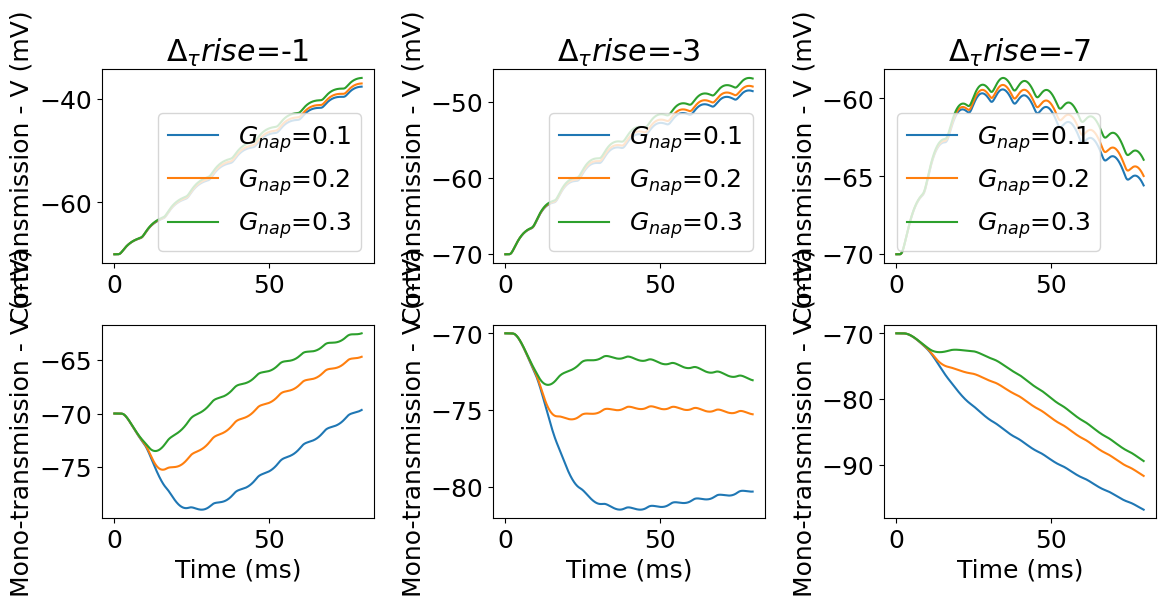

In [139]:
####### SOMA/DENDRITE COMPARTMENTS IN CORTICAL NEURONS

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
plt.rcParams.update({'font.size': 18})

def signal_trend(data):
    if np.argmin(data) > len(data)-3:
        return "decreasing"
    elif np.argmin(data) < 3:
        return "increasing"
    else:
        return "peaking"


plt.figure(figsize=(12,6))

for gnapbar in [0.1, 0.2, 0.3]:
    delay=0
    count=0

    width_block=1
    frequency = 120 #Hz



    for a in [1]:#np.arange(1,10,10):

        for b in [2,4,8]:#np.arange(1,10,2):

            g_AMPA_ext_E = 1#100.08 #nS
            tau_1 = a #ms
            tau_2 = 10 #ms

            g_GABA_E = 0.5 #nS
            tau_1g = b #10. #ms
            tau_2g=10

            t = 80
            
            dt = 0.1
            N = round(t/dt)
            ttotal = np.arange(0,t,dt)

            ## signal
            tspks = np.linspace(0,t,int(frequency/10))
            tspksi = [int(x/dt) for x in tspks]
            tspksf = [int((x+width_block)/dt) for x in tspks]
            amp=1
            syn = np.zeros_like(ttotal)
            for i in range(len(tspksi)):
                syn[tspksi[i]:tspksf[i]]=amp

            lat_e=1
            syn_ampa = np.zeros_like(ttotal)
            for o in range(len(tspksi)):
                syn_ampa[int(tspksi[o] + int(lat_e / dt)):int(tspksf[o] + int(lat_e / dt))] = 1  # Convert to int

            lat_i=2
            syn_gaba = np.zeros_like(ttotal)
            for o in range(len(tspksi)):
                syn_gaba[int(tspksi[o] + int(lat_i / dt)):int(tspksf[o] + int(lat_i / dt))] = 1  # Convert to int

            s_AMPA=0
            x_ampa=0

            s_GABA=0
            x_gaba=0

            Iacum_AMPA = []
            Iacum_GABA = []
            IacumCo =[ ]

            sg =[]
            sa = []

            ####neuron parameters
            v_soma = -70
            v_dend = -70
            gleak_soma = 1*(10**-4)
            gleak_dend = 1*(10**-4)
            Eleak_soma = -70
            Eleak_dend = -70
            vacum_soma = []
            vacum_dend = []

            ####second neuron
            v_soma2 = -70
            v_dend2 = -70
            vacum_soma2 = []
            vacum_dend2 = []

            ####third neuron
            v_soma3 = -70
            v_dend3 = -70
            vacum_soma3 = []
            vacum_dend3 = []

            ##ionic currrents
            mtau_p = 0.5
            Enap = 50
            minf_p = lambda x: 1/(1+np.exp(-(x+55)/3.3))	
            mp = 0
            mp2=0
            mp3=0
            inapacum =[]

            ####Coupling parameters
            g_coupling = 0.01  # coupling conductance
            

            for i in range(N):
                #vpre ---> I -> vpost

                s_AMPA = s_AMPA + dt*( ((tau_2/tau_1) ** (tau_1 / (tau_2 - tau_1))*x_ampa-s_AMPA)/tau_1 )
                x_ampa = x_ampa + dt*(-x_ampa/tau_2 + syn_ampa[i])
                Iacum_AMPA.append(g_AMPA_ext_E * s_AMPA)

                s_GABA = s_GABA + dt*( ((tau_2g/tau_1g) ** (tau_1g / (tau_2g - tau_1g))*x_gaba-s_GABA)/tau_1g )
                x_gaba = x_gaba + dt*(-x_gaba/tau_2g + syn_gaba[i])
                Iacum_GABA.append(- g_GABA_E * s_GABA)
                
                IacumCo.append(g_AMPA_ext_E * s_AMPA - g_GABA_E * s_GABA)

                #### Calculate Ionic Current for Soma
                Ileak_soma = gleak_soma * (v_soma - Eleak_soma)

                #### Calculate Ionic Current for Dendrite
                Ileak_dend = gleak_dend * (v_dend - Eleak_dend)
                Inap = gnapbar*mp*(v_dend - Enap)
                # inapacum.append(Inap)

                #### Calculate Coupling Current
                I_coupling = g_coupling * (v_soma - v_dend)

                #### Calculate Total Current for Soma and Dendrite
                I_total_soma =  - Ileak_soma - I_coupling + IacumCo[-1] #Iacum_GABA[-1] + Iacum_AMPA[-1]
                I_total_dend = - Ileak_dend + I_coupling - Inap - 0.5 #+ g_AMPA_ext_E * Iacum_AMPA[-1]

                #### Update Membrane Potentials
                v_soma = v_soma + dt * I_total_soma
                v_dend = v_dend + dt * I_total_dend
                mp = mp + dt* (minf_p(v_dend) - mp) / mtau_p

                vacum_soma.append(v_soma)
                vacum_dend.append(v_dend)

                #### Calculate Total Current for Soma and Dendrite second neuron
                Ileak_soma = gleak_soma * (v_soma2 - Eleak_soma)
                Ileak_dend = gleak_dend * (v_dend2 - Eleak_dend)
                I_coupling = g_coupling * (v_soma2 - v_dend2)
                Inap = gnapbar*mp2*(v_dend2 - Enap)
                inapacum.append(mp2)
                I_total_soma =  - Ileak_soma - I_coupling + Iacum_GABA[-1] 
                I_total_dend = - Ileak_dend + I_coupling +  Iacum_AMPA[-1] - Inap - 0.5

                #### Update Membrane Potentials
                v_soma2 = v_soma2 + dt * I_total_soma
                v_dend2 = v_dend2 + dt * I_total_dend
                mp2 = mp2 + dt* (minf_p(v_dend2) - mp2) / mtau_p

                vacum_soma2.append(v_soma2)
                vacum_dend2.append(v_dend2)

            peaks_AMPA, _ = find_peaks(Iacum_AMPA)
            peaks_GABA, _ = find_peaks(Iacum_GABA)

            Iacum_AMPA = np.asarray(Iacum_AMPA)
            Iacum_GABA = np.asarray(Iacum_GABA)

            filtered_signal_AMPA = gaussian_filter1d(Iacum_AMPA[peaks_AMPA], 4)
            filtered_signal_GABA = gaussian_filter1d(Iacum_GABA[peaks_GABA], 4)

            count = count + 1
            # plt.subplot(2, 3, count)

            # plt.plot(ttotal, Iacum_AMPA, c='b', label='AMPA')
            # plt.plot(ttotal, Iacum_GABA, c='r', label='GABA')
            # plt.plot(ttotal,IacumCo)
        
            # plt.plot(ttotal[peaks_AMPA], Iacum_AMPA[peaks_AMPA], 'bx')
            # plt.plot(ttotal[peaks_GABA], Iacum_GABA[peaks_GABA], 'rx')
            plt.subplot(2, 3, count)# + 3)
            
            # plt.title(r'$\Delta_\tau$' + f'={lat_e - lat_i}, $\Delta_g$ = {round(g_AMPA_ext_E - g_GABA_E, 2)}', fontsize=18)
            plt.title(r'$\Delta_\tau rise$' + f'={tau_1-tau_1g}')
            # plt.title(f'AMPA: {signal_trend(filtered_signal_AMPA)}, GABA: {signal_trend(filtered_signal_GABA)}')

            # plt.xlabel('Time (ms)') 
            
            plt.plot(ttotal, vacum_soma, label=r'$G_{nap}$='+str(gnapbar))
            plt.legend()
            plt.ylabel('Co-transmission - V (mV)')
            # plt.ylabel('Membrane Potential (mV)')

            plt.subplot(2, 3, count+3)
            plt.plot(ttotal, vacum_soma2)#,label='Mono-transmission')
            
            # plt.plot(ttotal, vacum_dend, label='Dendrite', c='r')
            plt.xlabel('Time (ms)')
            plt.ylabel('Mono-transmission - V (mV)')
            # plt.legend()
            plt.tight_layout()

plt.savefig('inap.png')
plt.savefig('inap.pdf')
plt.show()

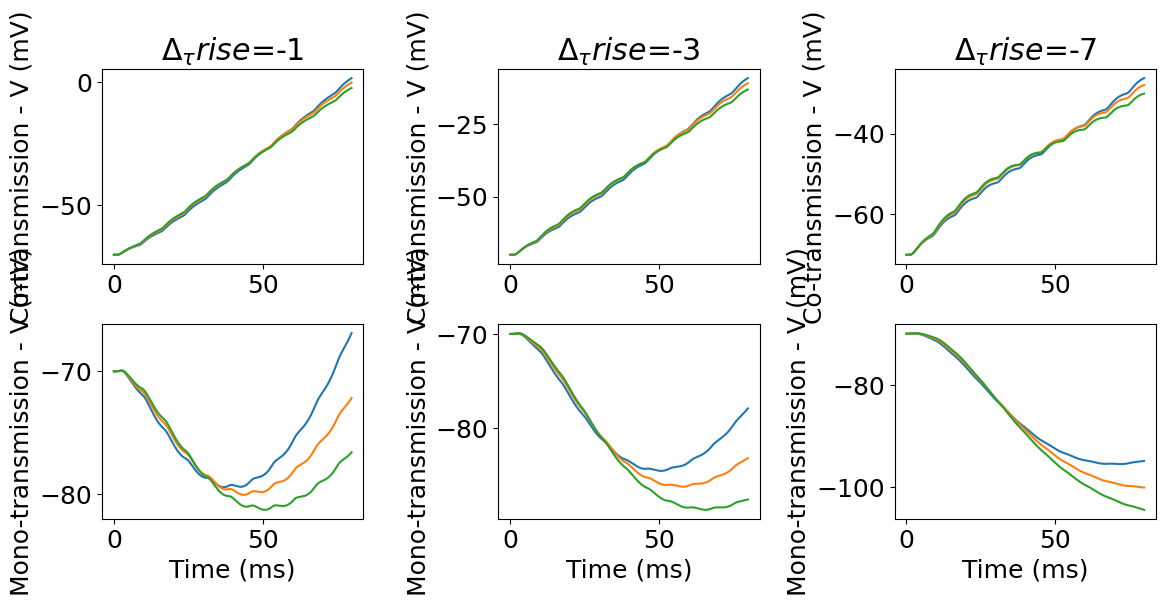

In [142]:
####### SOMA/DENDRITE COMPARTMENTS IN CORTICAL NEURONS

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
plt.rcParams.update({'font.size': 18})

def signal_trend(data):
    if np.argmin(data) > len(data)-3:
        return "decreasing"
    elif np.argmin(data) < 3:
        return "increasing"
    else:
        return "peaking"


plt.figure(figsize=(12,6))

for ghbar in [1, 5, 10]:
    delay=0
    count=0

    width_block=1
    frequency = 120 #Hz


    for a in [1]:#np.arange(1,10,10):

        for b in [2,4,8]:#np.arange(1,10,2):

            g_AMPA_ext_E = 1#100.08 #nS
            tau_1 = a #ms
            tau_2 = 10 #ms

            g_GABA_E = 0.5 #nS
            tau_1g = b #10. #ms
            tau_2g=10

            t = 80
            
            dt = 0.1
            N = round(t/dt)
            ttotal = np.arange(0,t,dt)

            ## signal
            tspks = np.linspace(0,t,int(frequency/10))
            tspksi = [int(x/dt) for x in tspks]
            tspksf = [int((x+width_block)/dt) for x in tspks]
            amp=1
            syn = np.zeros_like(ttotal)
            for i in range(len(tspksi)):
                syn[tspksi[i]:tspksf[i]]=amp

            lat_e=1
            syn_ampa = np.zeros_like(ttotal)
            for o in range(len(tspksi)):
                syn_ampa[int(tspksi[o] + int(lat_e / dt)):int(tspksf[o] + int(lat_e / dt))] = 1  # Convert to int

            lat_i=2
            syn_gaba = np.zeros_like(ttotal)
            for o in range(len(tspksi)):
                syn_gaba[int(tspksi[o] + int(lat_i / dt)):int(tspksf[o] + int(lat_i / dt))] = 1  # Convert to int

            s_AMPA=0
            x_ampa=0

            s_GABA=0
            x_gaba=0

            Iacum_AMPA = []
            Iacum_GABA = []
            IacumCo =[ ]

            sg =[]
            sa = []

            ####neuron parameters
            v_soma = -70
            v_dend = -70
            gleak_soma = 1*(10**-4)
            gleak_dend = 1*(10**-4)
            Eleak_soma = -70
            Eleak_dend = -70
            vacum_soma = []
            vacum_dend = []

            ####second neuron
            v_soma2 = -70
            v_dend2 = -70
            vacum_soma2 = []
            vacum_dend2 = []

            ##ionic currrents
            Eh=-43
            kh_m_inf = lambda x: 1/(1+np.exp((x+87)/8.9))
            kh_n_inf = lambda x: 1/(1+np.exp((x+87)/8.9)) 
            khm = 0 
            khn = 0 
            khm2 = 0
            khn2 = 0
            kh_m_tau= 10
            kh_n_tau= 100
            # ghbar = 0.54


            ####Coupling parameters
            g_coupling = 0.01  # coupling conductance
            

            for i in range(N):
                #vpre ---> I -> vpost

                s_AMPA = s_AMPA + dt*( ((tau_2/tau_1) ** (tau_1 / (tau_2 - tau_1))*x_ampa-s_AMPA)/tau_1 )
                x_ampa = x_ampa + dt*(-x_ampa/tau_2 + syn_ampa[i])
                Iacum_AMPA.append(g_AMPA_ext_E * s_AMPA)

                s_GABA = s_GABA + dt*( ((tau_2g/tau_1g) ** (tau_1g / (tau_2g - tau_1g))*x_gaba-s_GABA)/tau_1g )
                x_gaba = x_gaba + dt*(-x_gaba/tau_2g + syn_gaba[i])
                Iacum_GABA.append(- g_GABA_E * s_GABA)
                
                IacumCo.append(g_AMPA_ext_E * s_AMPA - g_GABA_E * s_GABA)

                #### Calculate Ionic Current for Soma
                Ileak_soma = gleak_soma * (v_soma - Eleak_soma)

                #### Calculate Ionic Current for Dendrite
                Ileak_dend = gleak_dend * (v_dend - Eleak_dend)
                aih = 0.5*khm + 0.5*khn
                Ih = ghbar*aih*(v_dend - Eh)
                
                # inapacum.append(Inap)

                #### Calculate Coupling Current
                I_coupling = g_coupling * (v_soma - v_dend)

                #### Calculate Total Current for Soma and Dendrite
                I_total_soma =  - Ileak_soma - I_coupling + IacumCo[-1] #Iacum_GABA[-1] + Iacum_AMPA[-1]
                I_total_dend = - Ileak_dend + I_coupling - Ih + 1.5# + Iacum_AMPA[-1]

                #### Update Membrane Potentials
                v_soma = v_soma + dt * I_total_soma
                v_dend = v_dend + dt * I_total_dend
                khm = khm + dt *(kh_m_inf(v_dend) - khm) / kh_m_tau
                khn = khn + dt* (kh_n_inf(v_dend) - khn) / kh_n_tau

                vacum_soma.append(v_soma)
                vacum_dend.append(v_dend)

                #### Calculate Total Current for Soma and Dendrite second neuron
                Ileak_soma = gleak_soma * (v_soma2 - Eleak_soma)
                Ileak_dend = gleak_dend * (v_dend2 - Eleak_dend)
                I_coupling = g_coupling * (v_soma2 - v_dend2)
                aih = 0.5*khm2 + 0.5*khn2
                Ih = ghbar*aih*(v_dend2 - Eh)
                inapacum.append(mp2)
                I_total_soma =  - Ileak_soma - I_coupling + Iacum_GABA[-1] 
                I_total_dend =  - Ileak_dend + I_coupling + Iacum_AMPA[-1] - Ih + 1.5

                #### Update Membrane Potentials
                v_soma2 = v_soma2 + dt * I_total_soma
                v_dend2 = v_dend2 + dt * I_total_dend
                mp2 = mp2 + dt* (minf_p(v_dend2) - mp2) / mtau_p
                khm2 = khm2 + dt *(kh_m_inf(v_dend2) - khm2) / kh_m_tau
                khn2 = khn2 + dt* (kh_n_inf(v_dend2) - khn2) / kh_n_tau

                vacum_soma2.append(v_soma2)
                vacum_dend2.append(v_dend2)

            peaks_AMPA, _ = find_peaks(Iacum_AMPA)
            peaks_GABA, _ = find_peaks(Iacum_GABA)

            Iacum_AMPA = np.asarray(Iacum_AMPA)
            Iacum_GABA = np.asarray(Iacum_GABA)

            filtered_signal_AMPA = gaussian_filter1d(Iacum_AMPA[peaks_AMPA], 4)
            filtered_signal_GABA = gaussian_filter1d(Iacum_GABA[peaks_GABA], 4)

            count = count + 1
            # plt.subplot(2, 3, count)

            # plt.plot(ttotal, Iacum_AMPA, c='b', label='AMPA')
            # plt.plot(ttotal, Iacum_GABA, c='r', label='GABA')
            # plt.plot(ttotal,IacumCo)
        
            # plt.plot(ttotal[peaks_AMPA], Iacum_AMPA[peaks_AMPA], 'bx')
            # plt.plot(ttotal[peaks_GABA], Iacum_GABA[peaks_GABA], 'rx')
            plt.subplot(2, 3, count)# + 3)
            
            # plt.title(r'$\Delta_\tau$' + f'={lat_e - lat_i}, $\Delta_g$ = {round(g_AMPA_ext_E - g_GABA_E, 2)}', fontsize=18)
            plt.title(r'$\Delta_\tau rise$' + f'={tau_1-tau_1g}')
            # plt.title(f'AMPA: {signal_trend(filtered_signal_AMPA)}, GABA: {signal_trend(filtered_signal_GABA)}')

            # plt.xlabel('Time (ms)') 
            
            plt.plot(ttotal, vacum_soma, label=r'$G_{h}$='+str(ghbar))
            # plt.legend()
            plt.ylabel('Co-transmission - V (mV)')
            # plt.ylabel('Membrane Potential (mV)')

            plt.subplot(2, 3, count+3)
            plt.plot(ttotal, vacum_soma2)#,label='Mono-transmission')
            
            # plt.plot(ttotal, vacum_dend, label='Dendrite', c='r')
            plt.xlabel('Time (ms)')
            plt.ylabel('Synaptic - V (mV)')
            # plt.legend()
            plt.tight_layout()

plt.savefig('ih.png')
plt.savefig('ih.pdf')
plt.show()